<a href="https://colab.research.google.com/github/nisaral/DL_practice_grounds/blob/main/Round2_Technograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install opendatasets

In [2]:
import opendatasets as od

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("electroknight/tg-flower")

print("Path to dataset files:", path)

100%|██████████| 87.0M/87.0M [00:01<00:00, 88.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/electroknight/tg-flower/versions/1


In [4]:
od.download("https://www.kaggle.com/datasets/electroknight/tg-flower")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: keyushnisar
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/electroknight/tg-flower


100%|██████████| 87.0M/87.0M [00:00<00:00, 238MB/s]


In [5]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
original_dataset_dir = '/content/tg-flower/Flower_1/flowers'  # Path to the main dataset folder
train_dir = 'flower_train'        # Folder to save training set
test_dir = 'flower_test'          # Folder to save testing set

# Create train and test directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Loop over each class folder in the original dataset
for class_folder in os.listdir(original_dataset_dir):
    class_path = os.path.join(original_dataset_dir, class_folder)

    if os.path.isdir(class_path):  # Check if it's a directory
        # Get list of all images in the class folder
        images = sorted(os.listdir(class_path))  # Sort to ensure consistent splitting

        # Define train and test split
        train_images = images[:250]   # First 250 images for training
        test_images = images[-50:]    # Last 50 images for testing

        # Create corresponding class folders in train and test directories
        train_class_dir = os.path.join(train_dir, class_folder)
        test_class_dir = os.path.join(test_dir, class_folder)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(test_class_dir, exist_ok=True)

        # Move images to the train folder
        for img in train_images:
            shutil.copy(os.path.join(class_path, img), train_class_dir)

        # Move images to the test folder
        for img in test_images:
            shutil.copy(os.path.join(class_path, img), test_class_dir)

print("Dataset successfully split into train and test folders.")

Dataset successfully split into train and test folders.


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "/content/flower_train"
test_dir = "/content/flower_test"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size = (224,224),
                                               batch_size=25,
                                               class_mode ='categorical'
                                               )
test_data = test_datagen.flow_from_directory(test_dir,
                                               target_size = (224,224),
                                               batch_size=25,
                                               class_mode ='categorical'
                                               )

Found 1250 images belonging to 5 classes.
Found 250 images belonging to 5 classes.


In [7]:
import tensorflow_hub as hub
import tensorflow as tf
hub_layer = hub.KerasLayer("https://kaggle.com/models/google/resnet-v2/TensorFlow2/50-feature-vector/1",
                   trainable=False)

hub_layer_wrapper = tf.keras.layers.Lambda(lambda x: hub_layer(x))

m = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),
    hub_layer_wrapper,
    tf.keras.layers.Dense(5, activation='softmax')
])

The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'resnet_v2_50/block3/unit_1/bottleneck_v2/conv2/weights:0' shape=(3, 3, 256, 256) dtype=float32>
  <tf.Variable 'resnet_v2_50/block2/unit_2/bottleneck_v2/conv2/BatchNorm/gamma:0' shape=(128,) dtype=float32>
  <tf.Variable 'resnet_v2_50/block1/unit_3/bottleneck_v2/conv2/BatchNorm/gamma:0' shape=(64,) dtype=float32>
  <tf.Variable 'resnet_v2_50/block3/unit_6/bottleneck_v2/conv2/weights:0' shape=(3, 3, 256, 256) dtype=float32>
  <tf.Variable 'resnet_v2_50/block3/unit_1/bottleneck_v2/shortcut/weights:0' shape=(1, 1, 512, 1024) dtype=float32>
  <tf.Variable 'resnet_v2_50/block2/unit_2/bottleneck_v2/conv2/weights:0' shape=(3, 3, 128, 128) dtype=float32>
  <tf.Variable 'resnet_v2_50/block4/unit_3/bottleneck_v2/conv2/BatchNorm/beta:0' shape=(512,) dtype=float32>
  <tf.Variable 'resnet_v2_50/block4/unit_1/bottleneck_v2/preact/beta:0' shape=(1024,) dtype=float32>
  <tf.Var

In [8]:
m.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [9]:
from keras import backend as K

In [10]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [11]:
m.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=[f1_score])

In [12]:
history = m.fit(train_data, epochs=4, validation_data=test_data)


Epoch 1/4
50/50 [==============================] - 44s 435ms/step - loss: 0.8129 - f1_score: 0.6614 - val_loss: 0.5265 - val_f1_score: 0.8162
Epoch 2/4
50/50 [==============================] - 21s 425ms/step - loss: 0.3482 - f1_score: 0.8851 - val_loss: 0.4524 - val_f1_score: 0.8514
Epoch 3/4
50/50 [==============================] - 21s 422ms/step - loss: 0.2438 - f1_score: 0.9228 - val_loss: 0.3992 - val_f1_score: 0.8561
Epoch 4/4
50/50 [==============================] - 21s 412ms/step - loss: 0.1877 - f1_score: 0.9481 - val_loss: 0.3819 - val_f1_score: 0.8689


In [13]:
m.evaluate(test_data)

10/10 [==============================] - 3s 335ms/step - loss: 0.3819 - f1_score: 0.8683


[0.381908118724823, 0.8683451414108276]

In [14]:
def precprocess_image(filename):
  img = tf.io.read_file(filename)
  img = tf.image.decode_image(img)
  img = tf.image.resize(img, (224, 224))
  img = img/255.
  return img

In [ ]:
img1 = precprocess_image("/content/Daisy.jpg")
img2 =precprocess_image("/content/Dandelion.jpg")
img3 =precprocess_image("/content/Rose.jpg")
img4 =precprocess_image("/content/SUnflower.jpg")
img5 =precprocess_image("/content/Tulip.jpg")


1/1 [==============================] - 0s 78ms/step


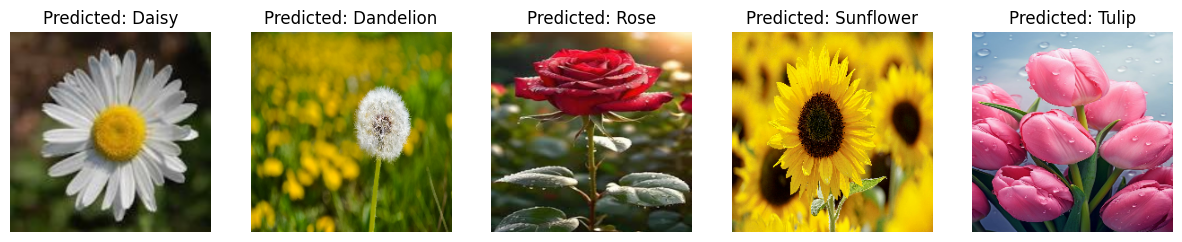

In [ ]:
import matplotlib.pyplot as plt

# Make predictions
predictions = []
for img in [img1, img2, img3, img4, img5]:
  prediction = m.predict(tf.expand_dims(img, axis=0))  # Add batch dimension
  predicted_class = tf.argmax(prediction, axis=1).numpy()[0]
  predictions.append(predicted_class)

# Define class names (assuming you have 5 classes: Daisy, Dandelion, Rose, Sunflower, Tulip)
class_names = ['Daisy', 'Dandelion', 'Rose', 'Sunflower', 'Tulip']

# Plot the images with predictions
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, img in enumerate([img1, img2, img3, img4, img5]):
  axes[i].imshow(img)
  axes[i].set_title(f"Predicted: {class_names[predictions[i]]}")
  axes[i].axis('off')

plt.show()

In [ ]:
test_image = "/content/PranavTest.jpg"
prediction = m.predict(tf.expand_dims(img, axis=0))  # Add batch dimension
predicted_class = tf.argmax(prediction, axis=1).numpy()[0]
predictions.append(predicted_class)

1/1 [==============================] - 0s 74ms/step


In [ ]:
preprocessed_image = precprocess_image(test_image)
prediction = m.predict(tf.expand_dims(img, axis=0))  # Add batch dimension
predicted_class = tf.argmax(prediction, axis=1).numpy()[0]
predicted_class

1/1 [==============================] - 0s 75ms/step


4

1/1 [==============================] - 0s 75ms/step


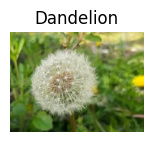

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # Import the module and alias it as 'mpimg'
import numpy as np
img = precprocess_image("/content/PranavTest.jpg")
img = tf.expand_dims(img, axis=0)
pred = m.predict(img)
plt.figure(figsize=(10,10)) # Create a figure with the desired figsize
plt.subplot(5,5,i)
plt.imshow(mpimg.imread("/content/PranavTest.jpg"))
plt.title(class_names[np.argmax(pred)])
plt.axis("off")
plt.show()